In [ ]:
데이터분석과기계학습 2주차 201884052 이지혁

In [25]:
import os
import pandas as pd


s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
print('URL:', s)

df = pd.read_csv(s,
                 header=None,
                 encoding='utf-8')

df.tail()

URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [26]:
# setosa와 versicolor를 선택합니다
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

# 꽃받침 길이와 꽃잎 길이를 추출합니다
X = df.iloc[0:100, [0, 2]].values

In [34]:
import matplotlib.pyplot as plt
import numpy as np

class AdalineSGD(object):
    '''
    ADAptive Linear Neuron 분류기
    
    Parameters
    -----
    eta : float
    학습률(0.0~1.0)
    
    n_iter : int
    훈련 데이터셋 반복 횟수
    
    shuffle : bool (default : True)
    True로 설정시 같은 반복이 되지 않도록 에포크마다 훈련 데이터를 섞음.
    
    random_state : int
    가중치 무작위 초기화를 위한 난수 생성기 시드
    
    Attributes
    -----
    w_ : 1d-array
    학습된 가중치
    
    cost_ : list
    모든 훈련 샘플에 대해 에포크마다 누적된 평균 비용 함수의 제곱합

    '''
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
    
    def fit(self, X, y):
        '''
        훈련 데이터 학습
        
        Parameters
        -----
        X : {array-like}, shape = [n_samples, n_features]
        n_samples 개의 샘플과 n_features 개의 특성으로 이루어진 훈련 데이터
        
        y : array-like, shape = [n_samples]
        타깃 벡터
        
        반환값
        -----
        self : object
        '''
        
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X,y = self._shuffle(X,y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self
    
    def partial_fit(self, X, y):
        '''가중치를 다시 초기화하지 않고 훈련 데이터를 학습함.'''
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X,y)
        return self
    
    def _shuffle(self, X, y):
        '''훈련 데이터를 섞음.'''
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        '''랜덤한 작은 수로 가중치를 초기화함.'''
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1+m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        '''아달린 학습 규칙을 적용하여 가중치를 업데이트함.'''
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta *- xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        '''입력 계산'''
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        '''선형 활성화 계산'''
        return X
    
    def predict(self, X):
        '''단위 계단 함수를 사용하여 클래스 레이블을 반환함.'''
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

In [37]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # 마커와 컬러맵을 설정합니다
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 샘플의 산점도를 그립니다
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

In [38]:
'''특성을 표준화함.'''
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

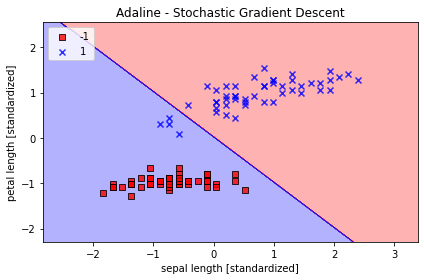

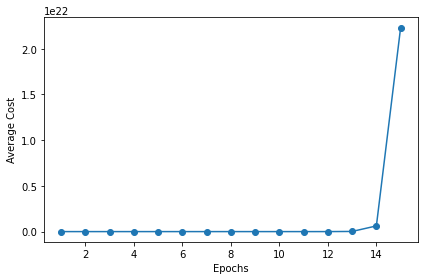

In [39]:
ada_sgd = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada_sgd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt. legend(loc='upper left')

plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada_sgd.cost_) +1), ada_sgd.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')

plt.tight_layout()
plt.show()

In [ ]:
잘 된건지는 모르겠지만 일단 그래프를 그리는데 성공하여서.. 과제제출 합니다.